In [1]:
! pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,f1_score
import transformers
from transformers import DistilBertTokenizer,DistilBertForSequenceClassification,RobertaModel,RobertaTokenizer,RobertaForSequenceClassification,BertForSequenceClassification,BertTokenizer
from transformers import Trainer,TrainingArguments,DataCollatorWithPadding
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import evaluate 

In [3]:
dataset=load_dataset('SetFit/amazon_reviews_multi_en')

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

validation.jsonl:   0%|          | 0.00/1.19M [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/1.18M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [7]:
train_df=pd.DataFrame(dataset['train'])
test_df=pd.DataFrame(dataset['test'])
valid_df=pd.DataFrame(dataset['validation'])

In [7]:
train_df

,id,text,label,label_text,new_labels,le_labels
0,en_0964290,Arrived broken. Manufacturer defect. Two of th...,0,0,Negative,0
1,en_0690095,the cabinet dot were all detached from backing...,0,0,Negative,0
2,en_0311558,I received my first order of this product and ...,0,0,Negative,0
3,en_0044972,This product is a piece of shit. Do not buy. D...,0,0,Negative,0
4,en_0784379,went through 3 in one day doesn't fit correct ...,0,0,Negative,0
...,...,...,...,...,...,...
199995,en_0046316,"Cute slippers, my MIL loved them.",4,4,Positive,2
199996,en_0956024,My 6 year old likes this and keeps him engaged...,4,4,Positive,2
199997,en_0589358,Replaced my battery with it. Works like new.,4,4,Positive,2
199998,en_0970602,"I like them, holding up well.",4,4,Positive,2


In [8]:
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [26]:
def compute_metrics(example):
    clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])
    labels = example.label_ids
    preds = example.predictions.argmax(-1)
    return  clf_metrics.compute(predictions=preds,references=labels)

In [10]:
train_df['new_labels'].value_counts()

new_labels
Negative    80000
Positive    80000
Neutral     40000
Name: count, dtype: int64

## Treating 3 star review as negative

In [19]:
train_df['new_labels']=train_df['label'].map({0:'Negative',1:'Negative',2:'Negative',3:'Positive',4:'Positive'})
test_df['new_labels']=test_df['label'].map({0:'Negative',1:'Negative',2:'Negative',3:'Positive',4:'Positive'})
valid_df['new_labels']=valid_df['label'].map({0:'Negative',1:'Negative',2:'Negative',3:'Positive',4:'Positive'})

In [20]:
le=LabelEncoder()
train_df['le_labels']=le.fit_transform(train_df['new_labels'])
valid_df['le_labels']=le.transform(valid_df['new_labels'])
test_df['le_labels']=le.transform(test_df['new_labels'])

In [21]:
train_df

,id,text,label,label_text,new_labels,le_labels
0,en_0964290,Arrived broken. Manufacturer defect. Two of th...,0,0,Negative,0
1,en_0690095,the cabinet dot were all detached from backing...,0,0,Negative,0
2,en_0311558,I received my first order of this product and ...,0,0,Negative,0
3,en_0044972,This product is a piece of shit. Do not buy. D...,0,0,Negative,0
4,en_0784379,went through 3 in one day doesn't fit correct ...,0,0,Negative,0
...,...,...,...,...,...,...
199995,en_0046316,"Cute slippers, my MIL loved them.",4,4,Positive,1
199996,en_0956024,My 6 year old likes this and keeps him engaged...,4,4,Positive,1
199997,en_0589358,Replaced my battery with it. Works like new.,4,4,Positive,1
199998,en_0970602,"I like them, holding up well.",4,4,Positive,1


In [22]:
tokenizer =DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
class ReviewData(Dataset):
    def __init__(self,dataframe,tokenizer):
        self.tokenizer=tokenizer
        self.data=dataframe
        self.text=dataframe.text
        self.targets=dataframe.le_labels
        # self.max_len=max_len
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self,index):
        text = str(self.text[index])
        label = torch.tensor(self.targets[index], dtype=torch.long)
        inputs = self.tokenizer(
            text,
            truncation=True,
            return_tensors='pt',
            padding='max_length',
        )
        ids = inputs['input_ids'].squeeze(0)
        mask = inputs['attention_mask'].squeeze(0)


        return {
            'input_ids': ids,
            'mask': mask,
            'labels': label
        }

In [24]:
training_set=ReviewData(train_df,tokenizer)
valid_set=ReviewData(valid_df,tokenizer)
test_set=ReviewData(test_df,tokenizer)

In [25]:
training_set[0]

{'input_ids': tensor([  101,  3369,  3714,  1012,  7751, 21262,  1012,  2048,  1997,  1996,
          3456,  1997,  1996,  2918,  2020,  2025,  3294,  2719,  1010,  2061,
          2045,  2001,  2053,  2126,  2000, 19274,  1996, 14542,  2869,  1012,
          1045,  4895, 23947, 18655,  1996,  2972,  3242,  1998,  8051,  2077,
         15103,  2023,  1012,  2061,  1010,  1045,  1005,  2222,  5247,  3807,
          1996,  3815,  1997,  2051,  8362,  2039,  1996,  2878, 11809,  2518,
          1998,  4604,  2009,  2067,  2007,  1037,  1015,  1011,  2732,  3319,
          1997,  2112,  1997,  1037,  3242,  1045,  2196,  2288,  2000,  4133,
          1999,  1012,  1045,  2097,  2175,  2061,  2521,  2004,  2000,  2421,
          1037,  3861,  1997,  2054,  2037, 13341, 18282,  2075,  1998,  3737,
         16375,  2832,  4771,  2295,  1012,  1045,  2097,  2022, 20221,  2000,
          4965,  2153,  1012,  2009,  3084,  2033,  4687,  2065,  2045,  4995,
          1005,  1056,  4394,  5090,  1

In [27]:
args = TrainingArguments(
    output_dir = "output",
    per_device_train_batch_size=16,
    per_device_eval_batch_size = 16,
    learning_rate = 3e-5,
    num_train_epochs = 2,
    eval_strategy = 'epoch',
    report_to="none",
    eval_steps=10000,  
    logging_steps=10000,        
    save_steps=10000,                
    save_total_limit=2, 
    weight_decay=0.01
)

In [28]:
trainer = Trainer(model=model,
                  args=args,
                  train_dataset = training_set,
                  eval_dataset = valid_set,
                  compute_metrics=compute_metrics,
                  tokenizer = tokenizer,
               )

In [29]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.304400,0.261081,0.896200,0.865718,0.897051,0.836500
2,0.232600,0.267743,0.900800,0.874112,0.887629,0.861000


TrainOutput(global_step=25000, training_loss=0.2579209912109375, metrics={'train_runtime': 11358.3209, 'train_samples_per_second': 35.216, 'train_steps_per_second': 2.201, 'total_flos': 5.29869594624e+16, 'train_loss': 0.2579209912109375, 'epoch': 2.0})

Confusion Matrix:
[[2787  213]
 [ 309 1691]]
              precision    recall  f1-score   support

    Negative       0.90      0.93      0.91      3000
    Positive       0.89      0.85      0.87      2000

    accuracy                           0.90      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.90      0.90      0.90      5000



<Axes: >

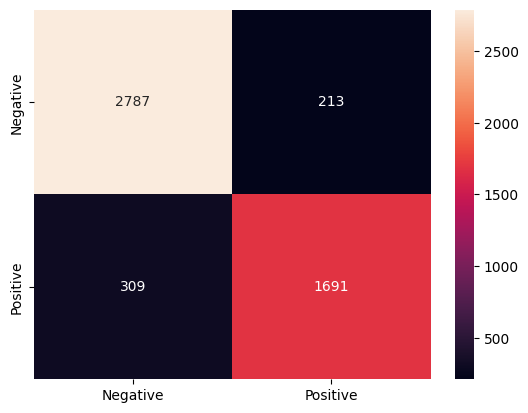

In [30]:
predictions_output = trainer.predict(test_set)
logits = predictions_output.predictions
true_labels = predictions_output.label_ids
predicted_labels = np.argmax(logits, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive"]) 
print("Confusion Matrix:")
print(cm)
print(report)
classes=["Negative", "Positive"]
sns.heatmap(cm,annot=True,fmt='g',xticklabels=classes,yticklabels=classes)

Confusion Matrix:
[[2782  218]
 [ 278 1722]]
              precision    recall  f1-score   support

    Negative       0.91      0.93      0.92      3000
    Positive       0.89      0.86      0.87      2000

    accuracy                           0.90      5000
   macro avg       0.90      0.89      0.90      5000
weighted avg       0.90      0.90      0.90      5000



<Axes: >

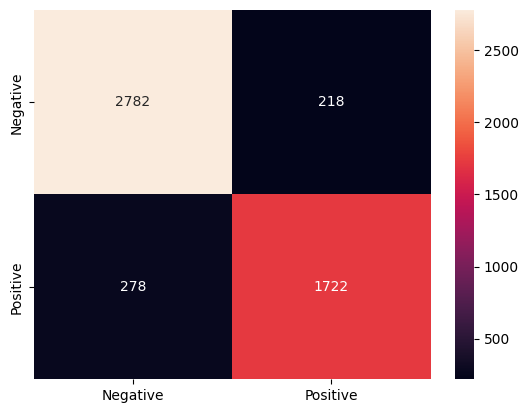

In [31]:
predictions_output = trainer.predict(valid_set)
logits = predictions_output.predictions
true_labels = predictions_output.label_ids
predicted_labels = np.argmax(logits, axis=1)
cm = confusion_matrix(true_labels, predicted_labels)
report = classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive"]) 
print("Confusion Matrix:")
print(cm)
print(report)
classes=["Negative", "Positive"]
sns.heatmap(cm,annot=True,fmt='g',xticklabels=classes,yticklabels=classes)

In [32]:
! mkdir /kaggle/working/distilbert_model

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [33]:
trainer.save_model("/kaggle/working/distilbert_model")
tokenizer.save_pretrained("/kaggle/working/distilbert_model")

('/kaggle/working/distilbert_model/tokenizer_config.json',
 '/kaggle/working/distilbert_model/special_tokens_map.json',
 '/kaggle/working/distilbert_model/vocab.txt',
 '/kaggle/working/distilbert_model/added_tokens.json')

In [36]:
import shutil
shutil.make_archive('distilbert', 'zip', '/kaggle/working/distilbert_model')

'/kaggle/working/distilbert.zip'

In [47]:
text = "This product is amazing!"
inputs = tokenizer(text, return_tensors="pt").to(device)
outputs = model(**inputs)
logits = outputs.logits
sentiment = torch.argmax(logits, dim=1).item()
print(sentiment)
print(torch.sigmoid(logits))

1
tensor([[0.0801, 0.9563]], device='cuda:0', grad_fn=<SigmoidBackward0>)
